Using the Hermite-Simpson Method: 
$$
\bar{y} = \frac{1}{2}(y_i+y_{i+1}) + \frac{h_i}{8}(f_i-f_{i+1}) \\
\bar{f} = f(\bar{y},t_i+\frac{h_i}{2}) \\
y_{i+1} = y_i +\frac{h_i}{6}(f_i+4\bar{f} + f_{i+1})
$$

Parmis les équations, la deuxième, où les deux paramètres d'équation dynamique sont pas donné directement, est le plus difficile à réalisé en considérant l'interpolation de l'état et du temps

In [4]:
using JuMP
using Ipopt
#using COPSBenchmark
import Plots

In [36]:
function rocket_model_hersim(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh,j=0:1],          (start=1.0)
        0.0 <= v[i=0:nh,j=0:1],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh,j=0:1] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh,j=0:1] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh,j=0:1],  D_c*v[i,j]^2*exp(-h_c*(h[i,j] - h_0))/h_0
        g[i=0:nh,j=0:1],  g_0 * (h_0 / h[i,j])^2
        dh[i=0:nh,j=0:1], v[i,j]
        dv[i=0:nh,j=0:1], (T[i,j] - D[i,j] - m[i,j]*g[i,j]) / m[i,j]
        dm[i=0:nh,j=0:1], -T[i,j]/c
    end)

    @objective(model, Max, h[nh,0])

    # Dynamics
    @constraints(model, begin
        con_dh[i=1:nh,j=0:1], h[i,j] == h[i-1,j] + 0.5 * step * (dh[i,j] + dh[i-1,j])
        con_dv[i=1:nh,j=0:1], v[i,j] == v[i-1,j] + 0.5 * step * (dv[i,j] + dv[i-1,j])
        con_dm[i=1:nh,j=0:1], m[i,j] == m[i-1,j] + 0.5 * step * (dm[i,j] + dm[i-1,j])  
    end)
    #Boundary constraints
    @constraints(model, begin
        h_ic, h[0,0] == h_0
        v_ic, v[0,0] == v_0
        m_ic, m[0,0] == m_0
        m_fc, m[nh,0] == m_f

        h_ic_1, h[0,1] == h_0
        v_ic_1, v[0,1] == v_0
        m_ic_1, m[0,1] == m_0
        m_fc_1, m[nh,1] == m_f
    end)

    return model
end

function Generate_thrust_hersim(nhs=nhs)
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    Thrusts = [[[] for i in range(1,length(nhs))] for j in range(1,2)]
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model_hersim(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        print(T_value)
        T_Array = Array(T_value[:,0]);
        T_Array_dua = Array(T_value[:,1]);
        Thrusts[1][i] = T_Array
        Thrusts[2][i] = T_Array_dua
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust_hersim (generic function with 2 methods)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     4208
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9800

Total number of variables............................:      809
                     variables with only lower bounds:      405
                variables with lower and upper bounds:      404
                     variables with only upper bounds:        0
Total number of equality constraints.................:      608
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Excessive output truncated after 524291 bytes.


 3.496264173230422      2.9633642012701227
 3.496242363360496      2.9612432247684324
 3.4962203692178844     2.9591165357100793
 3.4961981887465834     2.956984124743416
 3.4961758198620294     2.95484598277088
 3.4961532604506247     2.952702100950695
 3.496130508369253      2.950552470698598
 3.496107561444786      2.9483970836895934
 3.4960844174735803     2.9462359318597287
 3.4960610742209646     2.944069007407903
 3.4960375294207164     2.9418963027976868
 3.4960137807745295     2.9397178107591757
 3.4959898259514697     2.937533524290861
 3.4959656625874196     2.9353434366615208
 3.495941288284515      2.9331475414121364
 3.495916700610568      2.9309458323578266
 3.495891897098477      2.9287383035897996
 3.49586687524563       2.9265249494773307
 3.4958416325132893     2.9243057646697483
 3.4958161663259717     2.922080744098448
 3.4957904740708075     2.919849882978917
 3.495764553096895      2.917613176812773
 3.495738400714636      2.91537062138983
 3.4957120141950595   

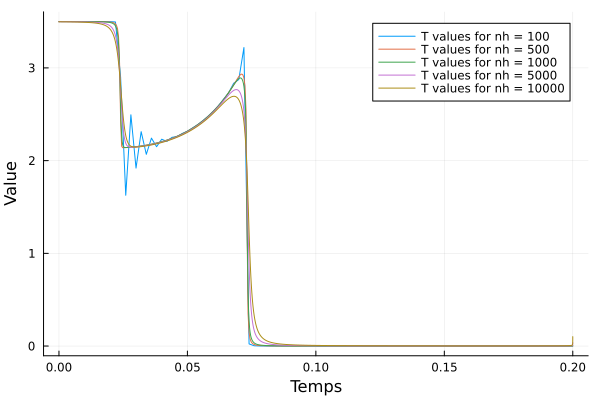

2-element Vector{Vector{Vector{Any}}}:
 [[3.499942913398764, 3.4999694884336203, 3.4999624728113097, 3.499952890594193, 3.499939349089585, 3.499919370775502, 3.4998881986316, 3.4998357379152916, 3.4997374106814862, 3.4995199974536675  …  1.9482288034400507e-5, 1.9938200573144967e-5, 2.0547240588164132e-5, 2.1367709169860057e-5, 2.249778128492947e-5, 2.4118646913184607e-5, 2.6613626849248718e-5, 3.1001638159049744e-5, 4.1761055468980716e-5, 0.0001067129889266206], [3.499741068375327, 3.4998687887728734, 3.499863773216827, 3.4998584885208404, 3.499852908939748, 3.499847010830845, 3.499840769231529, 3.4998341570845533, 3.499827144804689, 3.499819699900816  …  0.0001618072903995283, 0.00016961090404236267, 0.00017908950447296983, 0.00019091938612141967, 0.00020623418446984718, 0.00022712081357783865, 0.00025799174540055324, 0.00031060168950865485, 0.00043720066808845, 0.0011598853442244346], [3.499488455969033, 3.4997424632432916, 3.4997375966796302, 3.49973263239817, 3.4997275457291743, 3

In [37]:
nhs = [100,500,1000,5000,10000]
Thrusts = Generate_thrust_hersim()

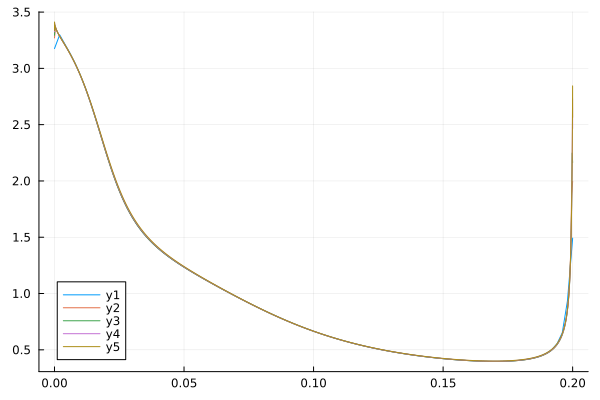

In [42]:
P = Plots.plot()
for thrusts in Thrusts[2]
    Plots.plot!(LinRange(0,0.2,length(thrusts)),thrusts)
end
Plots.display(P)